# Approximate Bayesian Computation

In [1]:
using Distributions, StatsPlots, Plots, StatsBase, LinearAlgebra,CSV, Random
using LaTeXStrings
using SymPy
using VegaLite
using DataFrames
pyplot()

Plots.PyPlotBackend()

## Discrete Example

In [177]:
n, x = 8, 6
N = 1_200

# Sample θ' from prior π(θ)
# Generate z from p(.|θ')
theta_s = rand(Beta(1,1),N)
z       = rand.(Binomial.(n,theta_s))
theta_a = theta_s[z .== x];
v = collect(range(0, stop=1, length=N));

# aux = sort(DataFrame(x1 = z, x2 = theta_s),:x2)
# z       = aux[!,:x1]
# theta_s = aux[!,:x2];

In [178]:
# k = collect(0:1:n)
# beta_distributions = pdf.(Beta.(x.+k',n .- k' .+1),v);
# plot(v,beta_distributions)

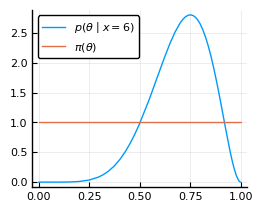

In [179]:
# histogram(theta_a,normalize=true,alpha=0.5)
plot(Beta(x+1,n-x+1),label=L"p(\theta \mid x=6)")
p = plot!(Beta(1,1), label =L"\pi(\theta)",size = (250, 200))
savefig(p,"./vis-project/static/images/distributions.png")

In [180]:
grid = collect(range(0,stop=1, length=N));
posterior = pdf.(Beta(x+1,n-x+1),grid);

In [181]:
cm = countmap(z)
counter = zeros(length(cm))
hdots = zeros(N)
for (i,v) in enumerate(z)
    counter[v+1]+=1
    hdots[i] = counter[v+1]
end


df = DataFrame([z,hdots,theta_s,collect(1:length(z)),ones(N),grid,posterior]);

In [182]:
CSV.write("./vis-project/data/ABC_Beta.csv",df)

"./vis-project/data/ABC_Beta.csv"

WARN Can not resolve event source: window
WARN Can not resolve event source: window
WARN Can not resolve event source: window
WARN Can not resolve event source: window


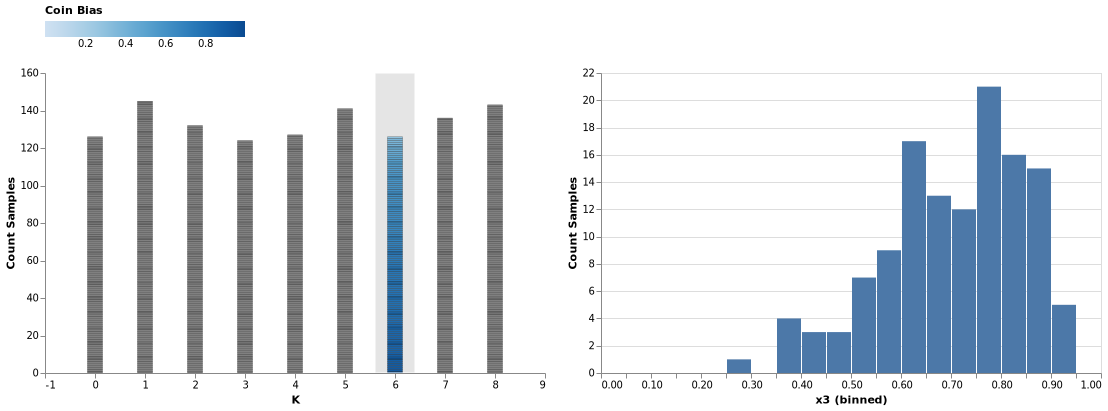

In [184]:
points = df |> vl"""
{
"hconcat" : [
  {

    "view":{"stroke" : null},
    "layer": [{

    
    "selection": {
      "brush": {"type": "interval","encodings": ["x"],"init":{"x": [5.6, 6.4]}}
    },
    "view":{"stroke" : null},
    "width": 500,
    "height": 300,
    "mark": {"type": "bar","stroke": "black",
    "strokeWidth": 0.2},
    "encoding": {
        "x": {"field": "x1", "type": "quantitative","axis": {"grid":false, "title":"K"},"scale":{"domain":[-0.1,8.1]}},
        "y": {"aggregate": "count","type": "quantitative", "axis": {"grid":false, "title":"Count Samples"}},
        "size":{"value":15},
        "color": {
              "condition": {"selection": "brush", "field": "x3", "type": "quantitative","title":"Coin Bias",
              "legend": {"orient": "top", "title": "Coin Bias"}
                            },
              "value": "grey"
            }
        }
}]},
  {
    "layer":[{
    "transform": [
      {"filter": {"selection": "brush"}}
    ],
    "width": 500,
    "height": 300,
    "mark": "bar",
    "encoding": {
    "x": {
        "bin":{"maxbins":20},
        "field": "x3",
        "type": "quantitative"
    },
    "y": {
        "aggregate": "count",
        "type": "quantitative",
        "title": "Count Samples"
      }
    }}
    ]
}]
}
"""

In [185]:
df[1:3,:]

3×7 DataFrame. Omitted printing of 1 columns
│ Row │ x1      │ x2      │ x3       │ x4      │ x5      │ x6          │
│     │ Float64 │ Float64 │ Float64  │ Float64 │ Float64 │ Float64     │
├─────┼─────────┼─────────┼──────────┼─────────┼─────────┼─────────────┤
│ 1   │ 2.0     │ 1.0     │ 0.324811 │ 1.0     │ 1.0     │ 0.0         │
│ 2   │ 3.0     │ 1.0     │ 0.483116 │ 2.0     │ 1.0     │ 0.000834028 │
│ 3   │ 6.0     │ 1.0     │ 0.538715 │ 3.0     │ 1.0     │ 0.00166806  │

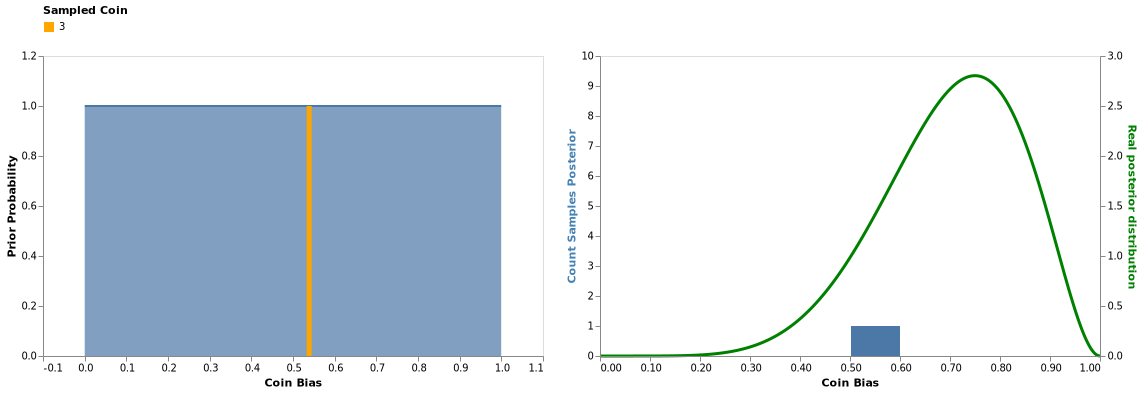

In [186]:
points = df |> vl"""
{
"hconcat" : [
  {
    "layer":[{
    "width": 500,
    "height": 300,
    "mark":{"type":"area","line":true},
    "encoding": {
    "x": {
        "field": "x3",
        "type": "quantitative",
        "axis":{"grid":false,"title":"Coin Bias"}
    },
    "y": {
        "field": "x5",
        "type": "quantitative",
        "axis":{"grid":false},
        "scale":{"domain":[0,1.2]}
      }
    }},{
    "width": 500,
    "height": 300,
    "transform": [
      {"filter": {"field": "x4", "equal":3}}
    ],
    "mark": {"type":"bar", "color":"orange"},
    "encoding": {
    "x": {
        "field": "x3",
        "type": "quantitative",
        "scale":{"domain":[0,1]},
            "axis":{"grid":false}
    },
    "y": {
        "field": "x5",
        "type": "quantitative",
        "title": "Prior Probability",
        "scale":{"domain":[0,1.2]}
      },
    "color":{"field":"x4","type":"nominal",
              "legend": {"orient": "top", "title": "Sampled Coin"},
              "scale": {
              "range": ["orange"]
              }}
            }
    }
    ]
},
{
    "layer":[{
    "width": 500,
    "height": 300,
    "transform": [
      {
        "filter":{"and":[{"field": "x1", "equal":6},
            {"field": "x4", "lte":3}]
        }
    }],
    "mark": "bar",
    "encoding": {
    "x": {
        "scale":{"domain":[0,1]},
        "bin": {
            "binned": false,
            "step": 0.1},
        "field": "x3",
        "type": "quantitative",
        "axis":{"grid":false,"title":"Coin Bias"}
    },
    "y": {
        "aggregate": "count",
        "type": "quantitative",
        "axis":{"grid":false, "title":"Count Samples Posterior", "titleColor":"steelblue"},
        "scale":{"domain":[0,10]}
      }
    }},
    {
    "width": 500,
    "height": 300,
          "mark": {"type": "line", "color": "green"},
          "encoding": {
            "x": {"type": "quantitative", "field": "x6"},
            "y": {
              "type": "quantitative",
              "field": "x7", "axis": {"title":"Real posterior distribution", "titleColor":"green"}
            },"size":{"value":3}
          }
        }
    ],"resolve": {"scale": {"y": "independent", "x": "shared"}}
}
]}
"""

In [9]:
# VegaLite.savespecpec("./ABC/data/ABC_Beta.vegalite", points)

## Continuos Example 

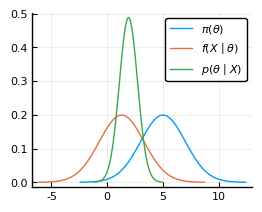

In [189]:
θ = 5.0
σ = 2.0
n = 5
Random.seed!(38);
y = rand(Normal(θ,σ),n) .-3
μ = mean(y)
τ = 2.0
μ1= (μ*n*(1/τ^2) + θ*(1/σ^2))/(n*(1/τ^2)+(1/σ^2))
τ1= sqrt(1/(n*(1/τ^2)+(1/σ^2)))
plot(Normal(θ,σ)   ,label=L"\pi(\theta)")
plot!(Normal(μ,τ)  ,label=L"f(X \mid \theta)")
p = plot!(Normal(μ1,τ1),label=L"p(\theta \mid X)",size=(250,200))
savefig(p,"./vis-project/static/images/normaldistribution.png")

In [210]:
N    = 2*(10^3)
θabc = rand(Normal(θ,σ),N)
z    = rand.(Normal.(θabc,σ),n);
zmean= mean.(z);
rawdistance(z) = sum((z .- y).^2)
ρ_raw   = rawdistance.(z) # Raw Disance
ρ_mean  = (zmean .- mean(y)).^2;
errormean =  zmean .- mean(y);

In [211]:
ϵ_raw  = quantile(ρ_raw,0.05)
ϵ_mean = quantile(ρ_mean,0.05)

0.3109092025625057

In [212]:
θabc_raw  = θabc[ρ_raw .<= ϵ_raw]
θabc_mean = θabc[ρ_mean .<= ϵ_mean];

In [213]:
# density(θabc_mean,normalize=true,lw=5,alpha=0.5)
# density!(θabc_raw,normalize=true,lw=5,alpha=0.5)
# plot(Normal(θ,σ),label=L"\pi(\theta)")
# plot!(Normal(μ,τ),label=L"f(X \mid \theta)")
# p = plot!(Normal(μ1,τ1),label=L"p(\theta \mid X)",size=(250,200))
# savefig(p,"./vis-project/static/images/normaldistribution.png")

In [214]:
grid = collect(range(-5,stop=8, length=N));
prior = pdf.(Normal(θ,σ),grid);
likelihood = pdf.(Normal(μ,τ),grid);
posterior = pdf.(Normal(μ1,τ1),grid);

In [215]:
scatter(zmean)
hline!([μ])
μ

1.2904318503509755

In [216]:
using LsqFit
m(t, p) = p[1].*t[:,1].+p[2]
model(t, p) = p[1].*t[:,1].+p[2].*t[:,2] .+ p[3]
p0 = [0.5, 0.1]
fit = curve_fit(m, errormean, θabc,p0)
fit.param

2-element Array{Float64,1}:
 0.8326246526186731
 1.9001097959434803

In [217]:
# scatter(errormean,θabc)
# plot!(errormean,fit.param[2] .+ fit.param[1].*errormean)

In [218]:
regression = fit.param[2] .+ fit.param[1].*errormean;

In [219]:
dfn = DataFrame(Zm=zmean,Theta=θabc,Error=errormean,Real=posterior, Prior = prior, Likelihood = likelihood,
    Grid=grid,Mu=μ.*ones(N),Id=collect(1:N),Regression=regression);

In [220]:
CSV.write("./vis-project/data/ABC_Normal.csv",dfn)

"./vis-project/data/ABC_Normal.csv"

WARN Can not resolve event source: window
WARN Can not resolve event source: window
WARN Can not resolve event source: window
WARN Can not resolve event source: window


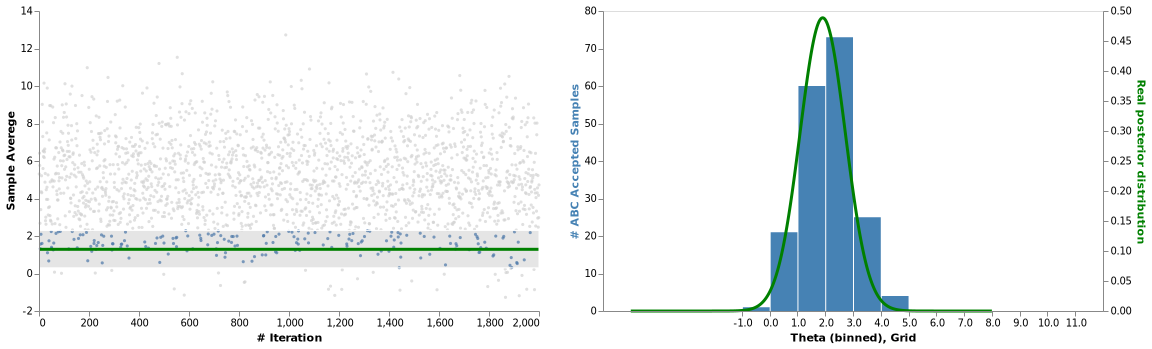

In [221]:
points = dfn |> vl"""
{
"hconcat" : [
  {

    "view":{"stroke" : null},
    "layer": [{
    
    
    "selection": {
      "brush": {"type": "interval","encodings": ["y"],"init":{"y": [0.3,2.3]}}
    },
    "view":{"stroke" : null},
    "width": 500,
    "height": 300,
    "mark": {"type": "circle"},
    "encoding": {
        "x": {"field": "Id", "type": "quantitative","axis": {"grid":false, "title":"# Iteration"}},
        "y": {"field": "Zm", "type":"quantitative","axis": {"grid":false, "title":"Sample Averege"}},
        "size":{"value":10},
        "color": {
              "condition": {"selection": "brush", "type": "quantitative","title":"Theta",
              "legend": {"orient": "top", "title": "Theta"}
                            },
              "value": "lightGrey"
            }
        }
},
{
    "view":{"stroke" : null},
    "width": 500,
    "height": 300,
    "mark": {"type": "line"},
    "encoding": {
        "x": {"field": "Id", "type": "quantitative","axis": {"grid":false}},
        "y": {"field": "Mu", "type":"quantitative"},
        "size":{"value":3},
        "color": {
              "value": "green"
            }
        }
}
]},
  {
    "layer":[
    {
    "transform": [
      {"filter": {"selection": "brush"}}
    ],
    "width": 500,
    "height": 300,
      "mark": {"type": "bar", "color": "steelblue","opacity":1.0},
      "encoding": {
        "x": {
            "bin":{"maxbins":20},
            "field": "Theta",
            "type": "quantitative"
        },
        "y": {
          "type": "quantitative",
          "aggregate": "count",
          "field": "Theta","axis":{"title":"# ABC Accepted Samples","titleColor":"steelblue"}
        }
      }
        },
        {
    "width": 500,
    "height": 300,
          "mark": {"type": "line", "color": "green"},
          "encoding": {
            "x": {"type": "quantitative", "field": "Grid"},
            "y": {
              "type": "quantitative",
              "field": "Real", "axis": {"title":"Real posterior distribution", "titleColor":"green"}
            },"size":{"value":3}
          }
        }
      ],
      "resolve": {"scale": {"y": "independent", "x": "shared"}}
}]
}
"""

WARN Can not resolve event source: window
WARN Can not resolve event source: window
WARN Can not resolve event source: window
WARN Can not resolve event source: window


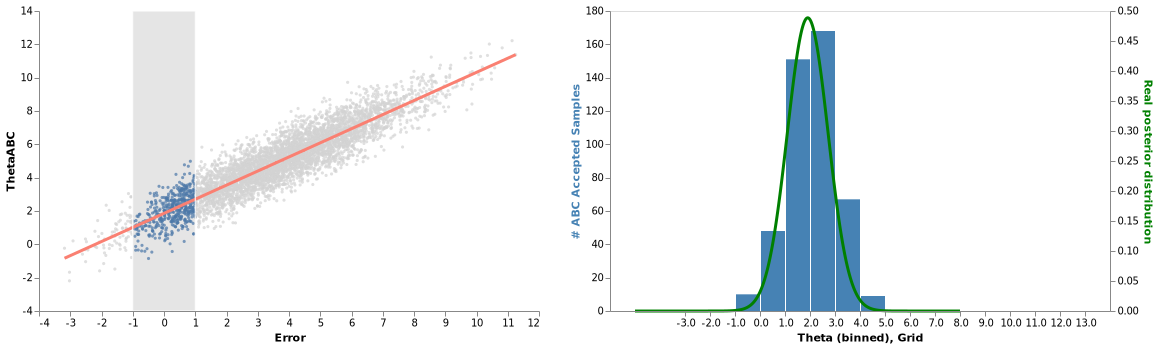

In [324]:
points = dfn |> vl"""
{
"hconcat" : [
  {

    "view":{"stroke" : null},
    "layer": [{

    
    "selection": {
      "brush": {"type": "interval","encodings": ["x"],"init":{"x": [-1,1]}}
    },
    "view":{"stroke" : null},
    "width": 500,
    "height": 300,
    "mark": {"type": "circle"},
    "encoding": {
        "x": {"field": "Error", "type": "quantitative","axis": {"grid":false, "title":"Error"}},
        "y": {"field": "Theta", "type":"quantitative","axis": {"grid":false, "title":"ThetaABC"}},
        "size":{"value":10},
        "color": {
              "condition": {"selection": "brush", "type": "quantitative","title":"Coin Bias",
              "legend": {"orient": "top", "title": "Coin Bias"}
                            },
              "value": "lightGrey"
            }
        }
},
{
    "view":{"stroke" : null},
    "width": 500,
    "height": 300,
    "mark": {"type": "line"},
    "encoding": {
        "x": {"field": "Error", "type": "quantitative","axis": {"grid":false}},
        "y": {"field": "Regression", "type":"quantitative"},
        "size":{"value":3},
        "color": {
              "value": "salmon"
            }
        }
}
]},
  {
    "layer":[
    {
    "transform": [
      {"filter": {"selection": "brush"}}
    ],
    "width": 500,
    "height": 300,
      "mark": {"type": "bar", "color": "steelblue","opacity":1.0},
      "encoding": {
        "x": {
            "bin":{"maxbins":20},
            "field": "Theta",
            "type": "quantitative"
        },
        "y": {
          "type": "quantitative",
          "aggregate": "count",
          "field": "Theta","axis":{"title":"# ABC Accepted Samples","titleColor":"steelblue"}
        }
      }
        },
        {
    "width": 500,
    "height": 300,
          "mark": {"type": "line", "color": "green"},
          "encoding": {
            "x": {"type": "quantitative", "field": "Grid"},
            "y": {
              "type": "quantitative",
              "field": "Real", "axis": {"title":"Real posterior distribution", "titleColor":"green"}
            },"size":{"value":3}
          }
        }
      ],
      "resolve": {"scale": {"y": "independent", "x": "shared"}}
}]
}
"""

In [326]:
dfn

5000×10 DataFrame. Omitted printing of 5 columns
│ Row  │ Zm       │ Theta    │ Error     │ Real        │ Prior      │
│      │ Float64  │ Float64  │ Float64   │ Float64     │ Float64    │
├──────┼──────────┼──────────┼───────────┼─────────────┼────────────┤
│ 1    │ 4.39422  │ 5.54747  │ 3.10379   │ 1.38767e-16 │ 7.4336e-7  │
│ 2    │ 5.17647  │ 4.64731  │ 3.88603   │ 1.42557e-16 │ 7.48208e-7 │
│ 3    │ 4.38414  │ 5.50817  │ 3.09371   │ 1.46448e-16 │ 7.53086e-7 │
│ 4    │ 3.99264  │ 5.09917  │ 2.70221   │ 1.50445e-16 │ 7.57995e-7 │
│ 5    │ 3.42733  │ 3.92225  │ 2.13689   │ 1.54549e-16 │ 7.62934e-7 │
│ 6    │ 4.36423  │ 5.25342  │ 3.0738    │ 1.58763e-16 │ 7.67905e-7 │
│ 7    │ 3.45314  │ 3.61846  │ 2.16271   │ 1.63091e-16 │ 7.72906e-7 │
│ 8    │ 10.0453  │ 9.016    │ 8.75486   │ 1.67535e-16 │ 7.77939e-7 │
│ 9    │ 5.08827  │ 5.0878   │ 3.79784   │ 1.72098e-16 │ 7.83003e-7 │
│ 10   │ 5.94738  │ 6.79009  │ 4.65695   │ 1.76784e-16 │ 7.88099e-7 │
⋮
│ 4990 │ 5.67759  │ 4.27133  │ 4.38716   │ 5.08598e-13 │ 0.0660287  │
│ 4991 │ 4.5312   │ 4.40623  │ 3.24077   │ 4.96704e-13 │ 0.0659011  │
│ 4992 │ 4.34924  │ 4.12527  │ 3.05881   │ 4.85082e-13 │ 0.0657736  │
│ 4993 │ 8.39143  │ 8.12824  │ 7.101     │ 4.73728e-13 │ 0.0656463  │
│ 4994 │ 0.414001 │ 0.888714 │ -0.876431 │ 4.62635e-13 │ 0.0655191  │
│ 4995 │ 3.52507  │ 4.0095   │ 2.23464   │ 4.51797e-13 │ 0.065392   │
│ 4996 │ 4.21265  │ 3.68511  │ 2.92222   │ 4.41209e-13 │ 0.0652651  │
│ 4997 │ 8.18631  │ 8.17353  │ 6.89588   │ 4.30864e-13 │ 0.0651383  │
│ 4998 │ 3.83636  │ 4.36788  │ 2.54593   │ 4.20758e-13 │ 0.0650117  │
│ 4999 │ 5.82605  │ 5.82974  │ 4.53562   │ 4.10885e-13 │ 0.0648852  │
│ 5000 │ 6.55105  │ 6.62442  │ 5.26062   │ 4.01239e-13 │ 0.0647588  │